In [1]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script to run and export ISSM relaxation
# Mikayla Pascual 07/13/22
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#import 
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

#import lhsmdu #install in terminal 'pip install lhsmdu'
import matplotlib.pyplot as plt
import pickle

import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt

from InterpFromGridToMesh import InterpFromGridToMesh
from InterpFromMeshToMesh2d import InterpFromMeshToMesh2d

In [2]:
md = loadmodel('./Models/SAtoES_inversion.nc')
#plotmodel(md, 'data', md.mask.ice_levelset)
md.levelset.spclevelset = np.nan * np.ones((md.mesh.numberofvertices))
pos = md.mesh.vertexonboundary == 1
#pos = np.where(md.mesh.vertexonboundary)
md.levelset.spclevelset[pos] = md.mask.ice_levelset[pos]
md.levelset.migration_max = 1e10
#plotmodel(md, 'data', md.mask.ice_levelset)

Opening ./Models/SAtoES_inversion.nc for reading 
solidearthsettings.solidearthsettings
lovenumbers.lovenumbers
rotational.rotational
results.solutionstep
empty init


In [3]:
# defining thermal and sub. discharge at every ISSM mesh node 

# load raster of basins
ds = gdal.Open('./Cheat_matfiles/tidewaterbasins_rignotid.mat_tidewaterbasins.tif', gdal.GA_ReadOnly)
rb = ds.GetRasterBand(1)
basins_array = rb.ReadAsArray()

gt = ds.GetGeoTransform()
ulx, xres, xskew, uly, yskew, yres  = gt
lrx = ulx + (ds.RasterXSize * xres)
lry = uly + (ds.RasterYSize * yres)
x = np.arange(ulx, lrx,  xres)
y = np.arange(lry, uly, -yres)


In [4]:
# interpolate basin to each mesh node 
px = np.array( ((md.mesh.x - gt[0]) / gt[1]).astype(int) )
py = np.array( ((md.mesh.y - gt[3]) / gt[5]).astype(int) )

basins_mesh = basins_array[py.astype(int), px.astype(int)]

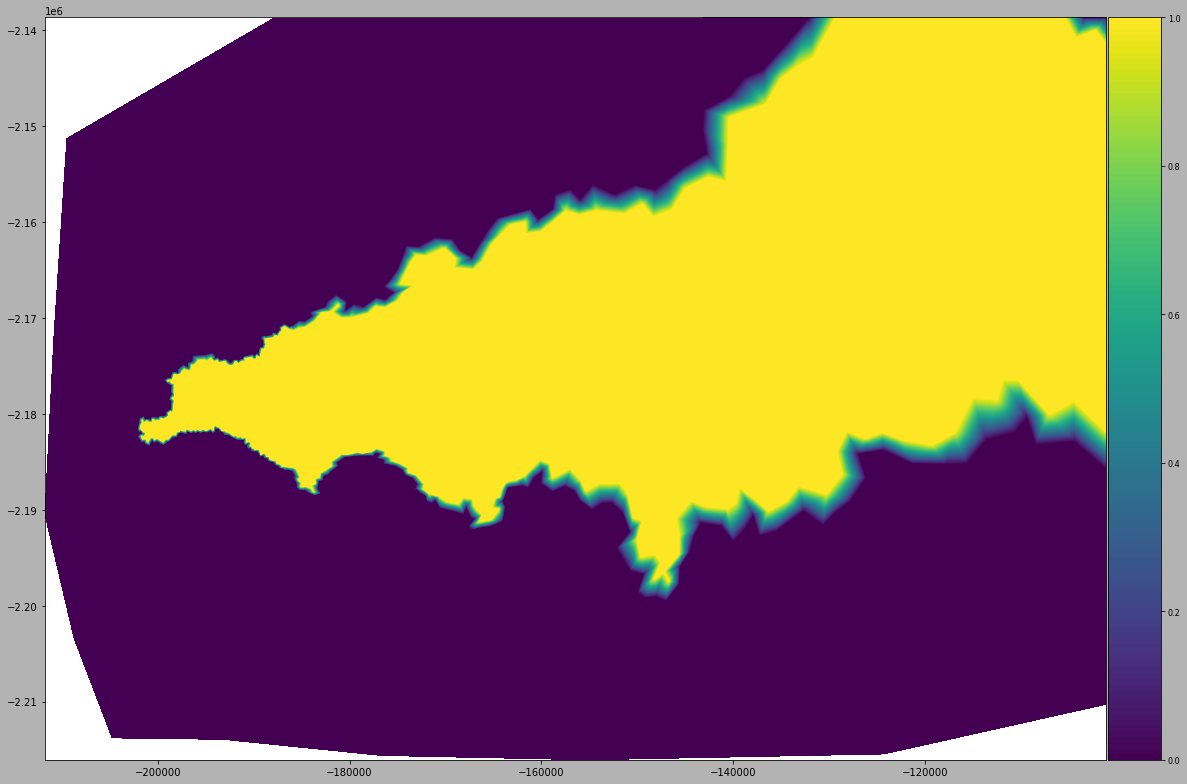

In [41]:
basins_mesh[basins_mesh==-9999] = 0
fig = plt.figure(figsize=(20,20))
plotmodel(md, 'data', (basins_mesh==13).astype(int)) #, 'edgecolor', 'k') #, 'caxis', [52, 54])
# basins_mesh == basin_id
#md.frontalforcing.thermal = basins_mesh==glacier_id

## Load discharge and thermal forcing

In [5]:
from scipy_io_utils import *

glacier_list = list()
m = loadmat('./Cheat_matfiles/glacier0013.mat')
glacier0013 = m['glacier0013']
m = loadmat('./Cheat_matfiles/glacier0052.mat')
glacier0052 = m['glacier0052']
m = loadmat('./Cheat_matfiles/glacier0053.mat')
glacier0053 = m['glacier0053']
m = loadmat('./Cheat_matfiles/glacier0090.mat')
glacier0090 = m['glacier0090']

In [6]:
# Thermal forcing
t = glacier0013['EN4']['t']
TF = glacier0013['EN4']['TF']

# Discharge
t = glacier0013['RACMO']['Q']
Q = glacier0013['RACMO']['Q']

In [46]:
from frontalforcingsrignot import frontalforcingsrignot
md.frontalforcings = frontalforcingsrignot()
md.frontalforcings.thermalforcing = np.zeros( (md.mesh.numberofvertices+1, len(glacier0013['EN4']['TF'])) )

In [50]:
# Assign forcings to correct node 

# step 1: find which nodes belong to basin 13 using basin_mesh
get_indexes = lambda basins_mesh, xs: [i for (y, i) in zip(xs, range(len(xs))) if basins_mesh == y]
glacier13_nodes = get_indexes(13,basins_mesh)
glacier52_nodes = get_indexes(52,basins_mesh)
glacier53_nodes = get_indexes(53,basins_mesh)
glacier90_nodes = get_indexes(90,basins_mesh)

# NOTE: Denis combined steps 2 and 3: we select the rows and set to the TF time series
# step 2: select() rows from frontalforcings.thermal that correspond to step 1 nodes
md.frontalforcings.thermalforcing[glacier13_nodes,:] = glacier0013['EN4']['TF']
md.frontalforcings.thermalforcing[glacier52_nodes,:] = glacier0052['EN4']['TF']
md.frontalforcings.thermalforcing[glacier53_nodes,:] = glacier0053['EN4']['TF']
md.frontalforcings.thermalforcing[glacier90_nodes,:] = glacier0090['EN4']['TF']

# NOTE: And now, set the last row to the time
md.frontalforcings.thermalforcing[-1,:] = glacier0013['EN4']['t']
# NOTE: All times are the same for the TF time series for each glacier so we just set the times equal to the glacier0013 times

# step 3: set select rows in frontalforcings to glacier 13 TF
#md.frontalforcings.thermalforcing = step2_nodes

# thermal_basins_mesh = np.zeros * np.array(md.mesh.numberofvertices, len(glacier0013['EN4']['t']))
# find where basin mesh coordinates with which glacier
# find() function to identify basins frmo xyz_array
# md.frontalforcings.thermal_basins = glacier0013['EN4']['TF']

In [60]:
len(glacier13_nodes)

3147

In [63]:
np.where(md.frontalforcings.thermalforcing == glacier13_nodes)

/tmp/ipykernel_316/1741595490.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.where(md.frontalforcings.thermalforcing == glacier13_nodes)


(array([], dtype=int64),)

In [ ]:
#test[numpy.logical_or.reduce([test[:,1] == x for x in wanted])]

In [20]:
md.mesh

   2D tria Mesh (horizontal):

      Elements and vertices:
         numberofelements       : 24063           -- number of elements
         numberofvertices       : 12112           -- number of vertices
         elements               : (24063, 3)      -- vertex indices of the mesh elements
         x                      : (12112,)        -- vertices x coordinate [m]
         y                      : (12112,)        -- vertices y coordinate [m]
         edges                  : (36174, 4)      -- edges of the 2d mesh (vertex1 vertex2 element1 element2)
         numberofedges          : 36174           -- number of edges of the 2d mesh

      Properties:
         vertexonboundary       : (12112,)        -- vertices on the boundary of the domain flag list
         segments               : (159, 3)        -- edges on domain boundary (vertex1 vertex2 element)
         segmentmarkers         : (159,)          -- number associated to each segment
         vertexconnectivity     : N/A      

In [8]:
glacier0013.keys()

dict_keys(['termpos', 'bjorkid', 'rignotid', 'lon', 'lat', 'x', 'y', 'dist2land', 'rignotname', 'RACMO', 'EN4', 'sector', 'sectornum', 'melt', 'MIROC5', 'NorESM', 'UKESM1', 'CESM2', 'CNRMESM2', 'CNRMCM6', 'HadGEM', 'CSIRO', 'IPSLCM', 'ACCESS', 'iceflux'])

In [14]:
glacier0013['termpos']['L']

array([ 0.        ,  0.43788323,  0.4557412 ,  0.50579075,  0.43264289,
        0.39634839,  0.25985531,  0.27695353,  0.07391255, -0.05107188,
       -0.09068249, -0.17559659,  0.18686365,  0.21687452,  0.31979162,
        0.0553805 ,  0.0293832 ,  0.04830657, -0.13293563,  0.15101694,
        0.21476642,  0.29742356,  0.37425494,  0.26890363,  0.25652603,
        0.19273306,  0.02627652,  0.03620638, -0.10649553,  0.06137705,
        0.24319368,  0.29288135,  0.37699268,  0.45310731,  0.52778685,
        0.54822756,  0.48930935,  0.41663074,  0.45550146,  0.50144745,
        0.628669  ,  0.67984796,  0.74511184,  0.74252117,  0.81550016,
        0.56125496,  0.47380105,  0.40324991,  0.65352046,  0.72248119,
        0.84989605,  0.8726854 ,  0.95895786,  0.82738536,  0.72054262,
        0.5458531 ,  0.43214992,  0.95892019,  0.93314094,  0.88780952,
        0.88409626,  0.80367259,  0.79838206,  0.66849062,  0.60382365,
        0.55577638,  0.5595309 ,  0.42708299,  0.49431128,  0.47

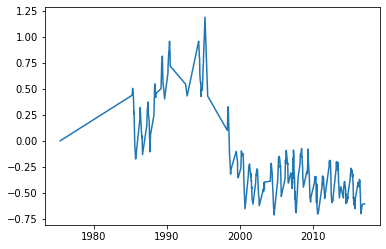

In [9]:
plt.plot(glacier0013['termpos']['t'],glacier0013['termpos']['L'])
# post processing comparisons:
    # average until present day
    # average year by year
    # model termini changes 

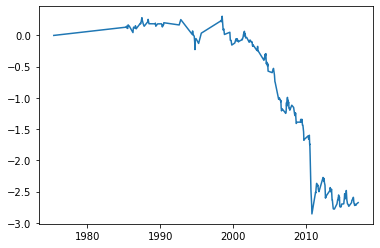

In [13]:
plt.plot(glacier0052['termpos']['t'],glacier0052['termpos']['L'])

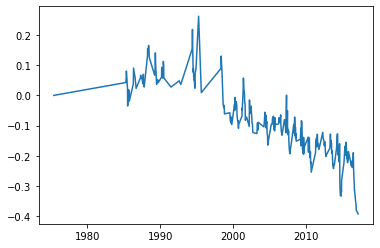

In [14]:
plt.plot(glacier0053['termpos']['t'],glacier0053['termpos']['L'])

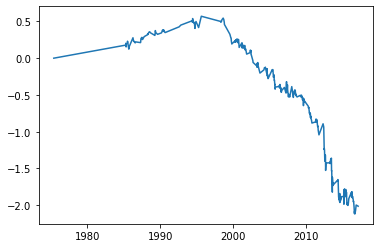

In [15]:
plt.plot(glacier0090['termpos']['t'],glacier0090['termpos']['L'])